In [2]:
%load_ext autoreload
%autoreload 2

import time

import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import albumentations as A

from dataset import *

data_valid_p = Path('data/data_valid.json')
data_train_p = Path('data/data_train.json')

In [3]:
MAX_STITCHES = 16

import json
with open(data_train_p, 'r') as f:
    data = json.load(f)

image_id = '190'

incision_points = np.array(data[image_id]['incision'], dtype=float)
stitches_points = np.array(data[image_id]['stitches'], dtype=float)

stitches_points2 = np.random.rand(MAX_STITCHES, 2, 2) * 20 - 10 # init with random vals around 0 --scale?
stitches_labels = np.zeros(MAX_STITCHES)
            
# distribute N stitches randomly through the final fixed sized stitches array
N = len(stitches_points)
indices = np.arange(MAX_STITCHES)
np.random.shuffle(indices)
stitches_points2[indices[:N], :] = stitches_points
stitches_labels[indices[:N]] = 1

stitches_points2 = stitches_points2.astype('float32')
stitches_points2 = stitches_points2.reshape([MAX_STITCHES*2, 2])

# print(stitches_labels)
# stitches_points2


In [4]:


stitches_points2 = np.random.rand(MAX_STITCHES, 2, 2) * 10
N = len(stitches_points)
for i in range(MAX_STITCHES):
    stitches_points2[i] += np.array([[12*(i+1), 30], [12*(i+1), 80]])
reg = np.array(stitches_points2)

stitches_labels = np.zeros(MAX_STITCHES)

for stitch_idx in range(N):
    stitch = stitches_points[stitch_idx]
    dist2regs = [99999]*MAX_STITCHES

    # sort stitch regressors for each stitch by distance
    for j in range(MAX_STITCHES):
        dist2regs[j] = np.linalg.norm(stitches_points[stitch_idx] - reg[j])
    closest_regs = np.argsort(dist2regs)

    for r_id in closest_regs:
        if stitches_labels[r_id] != 0:
            continue
        else: 
            stitches_labels[r_id] = 1
            stitches_points2[r_id, :] = stitches_points[stitch_idx]
            break


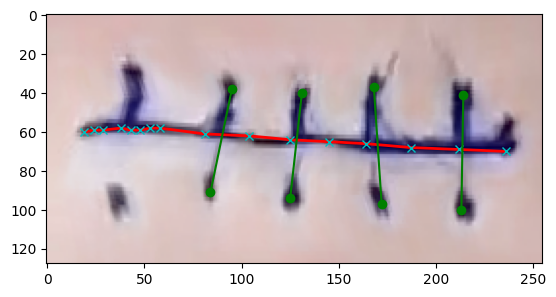

In [5]:
# INIT DATASET AND AUGMENTATIONS

# blur transforms 
transform_blur = A.Compose([
    A.OneOf([
    A.AdvancedBlur(p=0.8, blur_limit=(3,7)),
    A.Blur(p=0.8, blur_limit=5), 
    A.GaussianBlur(p=0.8),
    A.MedianBlur(p=0.8, blur_limit=5),
    A.MotionBlur(p=0.8, blur_limit=5)
  ], p=0.5) 
], keypoint_params=A.KeypointParams(format='xy'))
# spatial transforms
# TODO: add vertical flip ... requires flipping the order of points as well ... separate transform 
# TODO: handle when keypoints outside of img probably condition on len(keypoinst) when forward passing
transform_geom = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
      # TODO: when doing rotation some point easily gets out of picture
      A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=20, p=0.9),
      A.PiecewiseAffine(scale=(0.015, 0.025), p=0.9),
      A.Perspective(scale=(0.01, 0.03), p=0.9)  
    ], p=0.8)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

transform_color = A.Compose([
    A.OneOf([
        # A.ChannelDropout(p=0.8),
        A.ColorJitter(p=0.8),
        A.HueSaturationValue(p=0.8),
        A.RGBShift(p=0.8),
        A.RandomBrightnessContrast(p=0.8)
    ], p=0.5)
])
transform = A.Compose([transform_color, transform_blur, transform_geom])


train_dataset = ZdoDataset(data_train_p, normalize=True, transform=transform)
val_dataset = ZdoDataset(data_valid_p, normalize=True, transform=transform)


im, points, labels = train_dataset.__getitem__(10)
# points: 16x2: [incision | stitches]
visualize(im, points[:16,:], points[16:,:], stitch_objectness=labels, unnormalize=True)

In [7]:
import torch.nn as nn
from torchvision.models import vgg11, VGG11_Weights
from torchvision.models import resnet18, ResNet18_Weights


backbone_out = 512*4*7

# define model
class Model1(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.pretrained = pretrained_model
        self.fc1 = nn.Linear(backbone_out, 512) # intermediate layer between predictons
        self.fc_points_out = nn.Linear(512, 96) # 96 coordinates for 16 incisions + 16 stitches
        self.fc_objectness = nn.Linear(512, 16) # 1 value / stitch
        self.objectness_activation = nn.Sigmoid()
        self.dropout = nn.Dropout(0.4)
        self.APool = nn.AdaptiveAvgPool2d((1,1))

    
    def forward(self, x):
        x = nn.functional.relu(self.pretrained(x)) # shape (512, 4, 7) here (for (3,128,255))
        # x = self.APool(x)
        x = torch.flatten(x, start_dim=1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        p = torch.tanh(self.fc_points_out(x))
        o = self.objectness_activation(self.fc_objectness(x))
        return p, o
    
# load pretrained vgg + add its first module as conv feature backbone

weights = VGG11_Weights.DEFAULT
model = vgg11(weights=weights)
backbone = list(model.children())[0]
model = Model1(backbone)

# model_pretrained = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# backbone = nn.Sequential(*list(model_pretrained.children())[:-2])
# model = Model1(backbone)

print(model)

Model1(
  (pretrained): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

epoch: 0
train-epoch 0 loss: 0.0033847189846292008 time: 11.19s
val-epoch 0 loss: 0.037260086834430696 time: 13.62s
epoch: 1
train-epoch 1 loss: 0.003394292453221515 time: 9.69s
val-epoch 1 loss: 0.03727620989084244 time: 12.98s
epoch: 2
train-epoch 2 loss: 0.003440946472429596 time: 11.91s
val-epoch 2 loss: 0.03646935224533081 time: 13.80s
epoch: 3
train-epoch 3 loss: 0.0033526557736692176 time: 13.09s
val-epoch 3 loss: 0.036684826016426086 time: 16.16s
epoch: 4
train-epoch 4 loss: 0.0033026270370567793 time: 10.92s
val-epoch 4 loss: 0.03492802381515503 time: 13.79s
epoch: 5
train-epoch 5 loss: 0.003450447742917896 time: 9.73s
val-epoch 5 loss: 0.03895559906959534 time: 12.40s
epoch: 6
train-epoch 6 loss: 0.003363187993522239 time: 11.84s
val-epoch 6 loss: 0.037347590923309325 time: 15.17s
epoch: 7
train-epoch 7 loss: 0.003375054592579867 time: 11.02s
val-epoch 7 loss: 0.035172902047634125 time: 13.22s
epoch: 8
train-epoch 8 loss: 0.0032085758526768306 time: 9.24s
val-epoch 8 loss: 0.

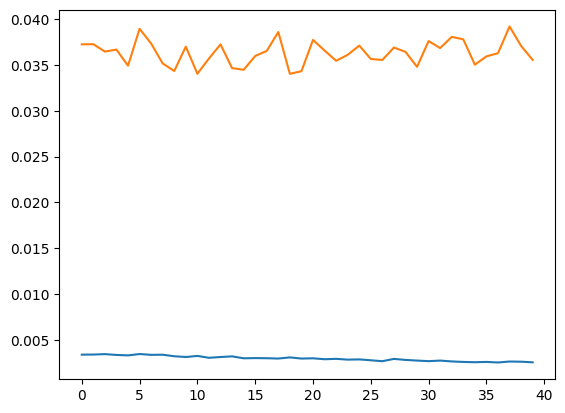

In [17]:
# TRAIN!
def train(net, dataloaders, optimizer, loss_det, loss_obj, num_epoch, device, validation=True, freq_print=10):
    net = net.to(device)
    loss_hist = np.ones((num_epoch,2))*np.inf
    a = 0.8
    b = 0.5
    for epoch in range(num_epoch):
        time_start = time.time()
        print(f"epoch: {epoch}")
        for loader_idx, phase in enumerate(dataloaders):
            if phase == 'train':
                net.train()
            else:
                if not validation:
                    break
                net.eval()

            loader = dataloaders[phase]
            running_loss = 0.0
            epoch_loss = 0.0
            # one batch
            for i, d in enumerate(loader, 0):
                inputs, points, labels = d
                points = points.flatten(start_dim=1) # as output of 32 neurons linear layer
                                
                inputs, points, labels = inputs.to(device), points.to(device), labels.to(device)
                
                #zero the grad!
                optimizer.zero_grad()

                out_p, out_o = net(inputs)

                # compute loss
                N = labels.sum() #number of correct
                
                incision_loss = a*loss_det(out_p[:,:32], points[:,:32])
                stitches_loss = loss_det(out_p[:,32:], points[:,32:]) / N
                objectness_loss = b*loss_obj(out_o, labels)
                loss = incision_loss + stitches_loss + objectness_loss

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
         
                # statistics
                running_loss += loss.item()
                epoch_loss += loss.item()

                if i % freq_print == (freq_print-1): 
                    print(f'{phase}: [{epoch + 1}, {i + 1:5d}] loss: {running_loss / freq_print:.3f}')
                    running_loss = 0.0 

            # normalize metrics by the size of data
            epoch_loss /= len(dataloaders[phase].dataset)
            loss_hist[epoch,loader_idx] = epoch_loss
            epoch_time = time.time() - time_start
            print(f"{phase}-epoch {epoch} loss: {epoch_loss} time: {epoch_time:.2f}s")
            
    print("training finished")
    plt.plot(loss_hist)
    
    return loss_hist

# setup dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=45, shuffle=True, num_workers=4)
val_dataloder = DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=4)

# train setup
dataloaders={'train': train_dataloader, 'val':val_dataloder}
num_epoch = 40
# optimizer = optim.SGD(model.parameters(), lr=0.1, momeentum=0.9)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss = nn.MSELoss()
loss_objectness = nn.BCELoss()

loss_hist = train(model, dataloaders, optimizer, loss, loss_objectness, num_epoch, device)

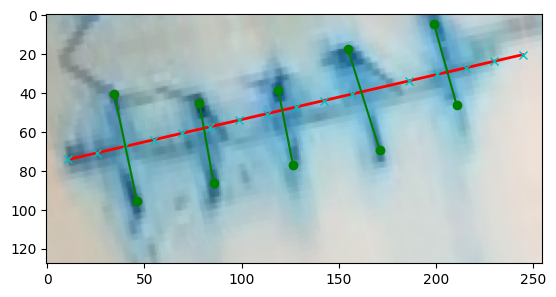

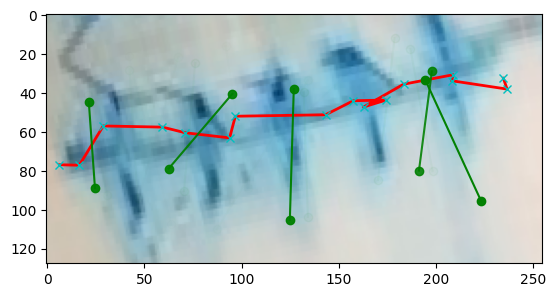

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [49]:
im, points_gt, stitchness_gt = val_dataset.__getitem__(1)
visualize(im, points_gt[:16,:], points_gt[16:,:], stitch_objectness=stitchness_gt.numpy(), unnormalize=True)


# prediction:
model.eval()
im2 = (im.unsqueeze(0)).to(device)
points_pred, stitchness = model(im2)
points_pred = points_pred.reshape([48,2]).detach().cpu()
stitchness = stitchness[0].detach().cpu().numpy()
visualize(im, points_pred[:16,:], points_pred[16:,:],  stitch_objectness=stitchness, unnormalize=True)
plt.figure()

In [43]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'checkpoints/vgg_all80.pth')

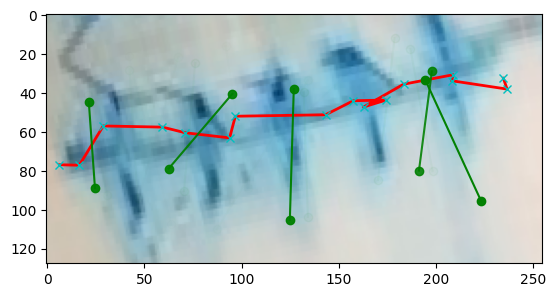

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [53]:
checkpoint = torch.load('checkpoints/vgg_all80.pth')

model_loaded = Model1(backbone)
model_loaded.load_state_dict(checkpoint['model_state_dict'])
model_loaded.eval()
model_loaded.to('cpu')

im2 = (im.unsqueeze(0)).to('cpu')
points_pred, stitchness = model_loaded(im2)
points_pred = points_pred.reshape([48,2]).detach().cpu()
stitchness = stitchness[0].detach().cpu().numpy()
visualize(im, points_pred[:16,:], points_pred[16:,:],  stitch_objectness=stitchness, unnormalize=True)
plt.figure()

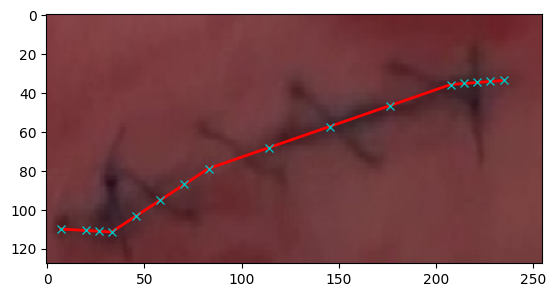

In [ ]:
im, incision = train_dataset.get_raw_item('77')
visualize(im, incision)

In [ ]:
len(incision)

16

In [ ]:
# hmmm
train_ids = list(train_dataset.images.keys())
valid_ids = list(val_dataset.images.keys())

print(f"train size: {len(train_ids)}")
for k in train_ids:
    if k in valid_ids: print("ajaaj")

train size: 116
